In [1]:
import numpy as np
import scipy
from scipy import integrate, interpolate
from scipy.misc import derivative
from scipy.special import comb
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities

In [2]:
c = 299792.458           #km/s
GN = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc = 3.086e19     # km

In [3]:
cosmo_params = {
...     'OmegaM' : 0.2999,
...     'OmegaDE': 0.7,
...     'OmegaR' : 1.e-4,
...     'h'     : 0.7,
... }

In [4]:
ligo_asd = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
etd_asd = np.genfromtxt('../data/ET-0000A-18_ETDSensitivityCurveTxtFile.txt')
ce_asd = np.genfromtxt('../data/ce_strain.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_O1_asd = np.genfromtxt('../data/L1_O1_strain.txt')

In [5]:
ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
etd_interp = interpolate.interp1d(etd_asd[:,0],etd_asd[:,3])
ce_interp = interpolate.interp1d(ce_asd[:,0],ce_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

ligo_O1_interp = interpolate.interp1d(ligo_O1_asd[:,0],ligo_O1_asd[:,1])

In [14]:
# phase for exact Delta
def Psi_Delta_exact(fo, fstar, c0, Mz, eta, zem, tc, psic, cT_type='EFT', width=0):

    Q_1 = - (743./336 + 11./4*eta)*eta**(-2./5)
    Q_1p5 = (4*np.pi-0) *eta**(-3./5)
    Q_2 = (34103./18144 + 13661./2016*eta + 59./18*eta**2) *eta**(-4./5)
    Q_2p5 = -np.pi/eta*(4159./672+189./8*eta)

    if cT_type=='EFT':
        Delta = delta_EFT(fo,c0,zem,fstar)
        d_Delta_dfo_func = lambda fo_func: delta_EFT(fo_func, c0, zem, fstar)
    elif cT_type=='step':
        Delta = Delta_step(fo,c0,zem,fstar,width)
        d_Delta_dfo_func = lambda fo_func: Delta_step(fo_func, c0, zem, fstar, width)

    Mo_arr = Mz / (1-Delta)

    uo_arr = np.pi * Mo_arr * fo

    d_Delta_dfo = derivative(d_Delta_dfo_func, fo, fo*1e-3)

    to_int = 5*np.pi*(Mz)**2/96 / (1-Delta)**2 * (1 + fo/(1-Delta)*d_Delta_dfo) * uo_arr**(-11./3) * (1 - Q_1*uo_arr**(2./3) - Q_1p5*uo_arr + (Q_1**2-Q_2)*uo_arr**(4./3) + (2*Q_1*Q_1p5-Q_2p5)*uo_arr**(5./3))

    t_o = np.zeros(len(fo))
    Psi = np.zeros(len(fo))

    for i in range(len(fo)):
        t_o[i] = integrate.simps(-to_int[i:], x=fo[i:])

    Psi_int = 2*np.pi * t_o

    for i in range(len(fo)):
        Psi[i] = integrate.simps(-Psi_int[i:], x=fo[i:]) - np.pi/4 + 2*np.pi*fo[i]*tc - psic

    return Psi

# amplitude for exact Delta
def amp_Delta_exact(fo, fstar, c0, Mz, eta, zem, cosmo_params, cT_type='EFT', width=0):

    if cT_type=='EFT':
        Delta = delta_EFT(fo,c0,zem, fstar)
        cT_fo = cT_EFT(fo, fstar, c0)
    elif cT_type=='step':
        Delta = Delta_step(fo,c0,zem, fstar, width)
        cT_fo = cT_step(fo, fstar, c0, width)

    dl_GR = utilities.DGW(zem, fo, cosmo_params)
    dl_MG = dl_GR / np.sqrt(1-Delta) * cT_fo
    amp_MG = utilities.Amplitude(fo, Mz, eta, dl_MG*Mpc/c, False) * (1-Delta)**(2./3)

    return amp_MG

class waveform_delta(object):

    def __init__(self, cT_type, width=0):

        self.cT_type = cT_type
        self.width = width

    def h_Delta_exact(self, fo, pars, cosmo_params):

        Mz          = np.exp(pars[0]) * Msolar * GN/ (1e3 *c)**3
        eta         = np.exp(pars[1])
        zem           = np.exp(pars[2])
        tc          = pars[3]
        psic       = pars[4]
        c0 = pars[5]
        fstar = pars[6]

        amp = amp_Delta_exact(fo, fstar, c0, Mz, eta, zem, cosmo_params, self.cT_type, self.width)
        Psi = Psi_Delta_exact(fo, fstar, c0, Mz, eta, zem, tc, psic, self.cT_type, self.width)

        return amp * np.exp(1.j*Psi)

def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result

def cT_step(farr, fstar, c0, width):
    
    cT_val = np.zeros((len(farr)))

    for i in range(len(farr)):
        if farr[i]<fstar:
            cT_val[i] = c0
        else:
            cT_val[i] = 1

    return cT_val

def Delta_step(farr, c0,zem,fstar, width):

    cT_step_fo = cT_step(farr, fstar, c0, width)
    cT_step_fs = cT_step(farr*(1+zem), fstar, c0, width)

    return 1-cT_step_fo/cT_step_fs


In [7]:
m1 = 36       #solormass
m2 = 29

Dl = 410      #Mpc
zem = 0.09

time = 20*365*24*3600    # time before merger in sec

tc = 0
psic = 0

In [8]:
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger

f_cut = utilities.get_freq(Mtot_s, eta, "cut")

fc = utilities.inspiral_fc(Mtot_s)

farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)

Dl_arr = np.array([Dl_s]*len(farr))

f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)

In [9]:
mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
mask_etd = (farr>etd_asd[0,0]) & (farr<=etd_asd[-1,0])
mask_ce = (farr>ce_asd[0,0]) & (farr<=ce_asd[-1,0])
mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

In [10]:
ligo_psd = ligo_interp(farr[mask_ligo])**2
etd_psd = etd_interp(farr[mask_etd])**2
ce_psd = ce_interp(farr[mask_ce])**2
lisa_psd = lisa_interp(farr[mask_lisa])

In [26]:
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

In [27]:
h_GR = utilities.waveform(farr, pars_GR, cosmo_params)

In [29]:
psi_step_GR = Psi_Delta_exact(farr[mask_lisa], 10, 1, Ms, eta, zem, tc, psic, cT_type='step', width=0)


In [19]:
fstar_test = 1000
c0_test = 0.3

In [20]:
pars_step_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0_test, fstar_test]

In [21]:
h_Delta_step_test = waveform_delta(cT_type='step', width=0).h_Delta_exact(farr, pars_step_GR, cosmo_params)

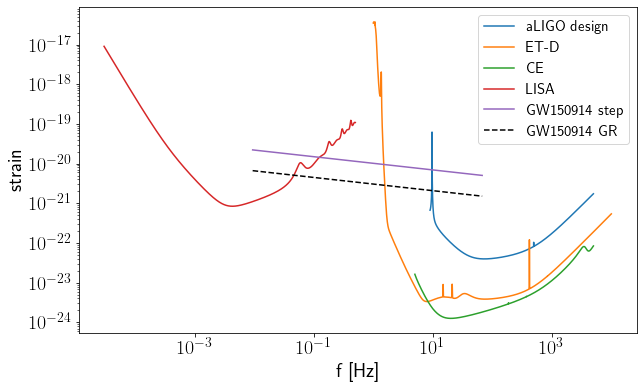

In [28]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(etd_asd[:,0],np.sqrt(etd_asd[:,0])*etd_asd[:,3],label='ET-D')
plt.loglog(ce_asd[:,0],np.sqrt(ce_asd[:,0])*ce_asd[:,1],label='CE')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_test), label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

In [22]:
waveform_test = waveform_delta(cT_type='step', width=0).h_Delta_exact

# numerical derivatives w.r.t. lnMz
dh_dlnMz_func = lambda lnMz_func: waveform_test(farr[mask_lisa], [lnMz_func, np.log(eta), np.log(zem), tc, psic, c0_test, fstar_test], cosmo_params)
dh_dlnMz_lisa_step_test = derivative(dh_dlnMz_func, np.log(Ms), dx=np.log(Ms)*1.e-8)

# numerical derivatives w.r.t. lneta
dh_dlneta_func = lambda lneta_func: waveform_test(farr[mask_lisa], [np.log(Ms), lneta_func, np.log(zem), tc, psic, c0_test, fstar_test], cosmo_params)
dh_dlneta_lisa_step_test = derivative(dh_dlneta_func, np.log(eta), dx=np.log(eta)*1.e-4)

# numerical derivatives w.r.t. lnz
dh_dlnz_func = lambda lnz_func: waveform_test(farr[mask_lisa], [np.log(Ms), np.log(eta), lnz_func, tc, psic, c0_test, fstar_test], cosmo_params)
dh_dlnz_lisa_step_test = derivative(dh_dlnz_func, np.log(zem), dx=np.log(zem)*1.e-3)

dh_dtc_func = lambda tc_func: waveform_test(farr[mask_lisa], [np.log(Ms), np.log(eta), np.log(zem), tc_func, psic, c0_test, fstar_test], cosmo_params)
dh_dtc_lisa_step_test = derivative(dh_dtc_func, tc, dx=1.e-3)

# numerical derivatives w.r.t. psic
dh_dpsic_func = lambda psic_func: waveform_test(farr[mask_lisa], [np.log(Ms), np.log(eta), np.log(zem), tc, psic_func, c0_test, fstar_test], cosmo_params)
dh_dpsic_lisa_step_test = derivative(dh_dpsic_func, psic, dx=1.e-3)

dh_dc0_func = lambda c0_func: waveform_test(farr[mask_lisa], [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0_func, fstar_test], cosmo_params)
dh_dc0_lisa_step_test = derivative(dh_dc0_func, c0_test, dx=1.e-6)

derivatives = [dh_dlnMz_lisa_step_test, dh_dlneta_lisa_step_test, dh_dlnz_lisa_step_test, dh_dtc_lisa_step_test, dh_dpsic_lisa_step_test, dh_dc0_lisa_step_test]
nparams = len(derivatives)
Fisher_matrix_test = np.zeros((nparams,nparams))

for i in range(0,nparams):
    for j in range(0,nparams):
        Fisher_matrix_test[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], lisa_psd, farr[mask_lisa])

connum = np.linalg.cond(Fisher_matrix_test)
print(connum)
cov_matrix_test = np.linalg.inv(Fisher_matrix_test)
pconstraints_test = np.sqrt(np.diag(cov_matrix_test))
print(pconstraints_test)

3.183965294890918e+29
[1.22036177e-07 8.18545597e-04 2.62816803e+06 7.36931388e-01
 2.05090365e-01 8.36713343e+05]


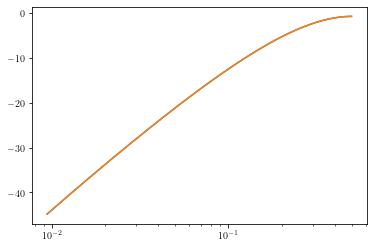

In [30]:
psi_step_test = Psi_Delta_exact(farr[mask_lisa], fstar_test, c0_test, Ms, eta, zem, tc, psic, cT_type='step', width=0)

plt.semilogx(farr[mask_lisa], psi_step_GR)
plt.semilogx(farr[mask_lisa], psi_step_test)

In [48]:
fstar_test2 = 0.1
c0_test2 = 0.3
w = 0.5

In [49]:
pars_step_GR2 = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0_test2, fstar_test2]

In [50]:
h_Delta_step_test2 = utilities.waveform_delta(cT_type='step', width=w).h_Delta_exact(farr, pars_step_GR2, cosmo_params)

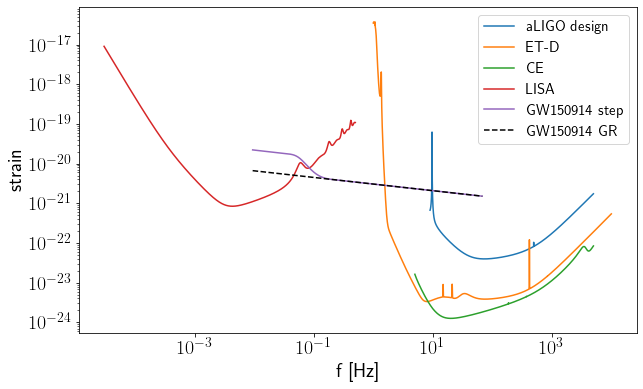

In [51]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(etd_asd[:,0],np.sqrt(etd_asd[:,0])*etd_asd[:,3],label='ET-D')
plt.loglog(ce_asd[:,0],np.sqrt(ce_asd[:,0])*ce_asd[:,1],label='CE')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_test2), label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

In [52]:
waveform_test2 = utilities.waveform_delta(cT_type='step', width=w).h_Delta_exact

# numerical derivatives w.r.t. lnMz
dh_dlnMz_func = lambda lnMz_func: waveform_test2(farr[mask_lisa], [lnMz_func, np.log(eta), np.log(zem), tc, psic, c0_test, fstar_test], cosmo_params)
dh_dlnMz_lisa_step_test2 = derivative(dh_dlnMz_func, np.log(Ms), dx=np.log(Ms)*1.e-8)

# numerical derivatives w.r.t. lneta
dh_dlneta_func = lambda lneta_func: waveform_test2(farr[mask_lisa], [np.log(Ms), lneta_func, np.log(zem), tc, psic, c0_test, fstar_test], cosmo_params)
dh_dlneta_lisa_step_test2 = derivative(dh_dlneta_func, np.log(eta), dx=np.log(eta)*1.e-4)

# numerical derivatives w.r.t. lnz
dh_dlnz_func = lambda lnz_func: waveform_test2(farr[mask_lisa], [np.log(Ms), np.log(eta), lnz_func, tc, psic, c0_test, fstar_test], cosmo_params)
dh_dlnz_lisa_step_test2 = derivative(dh_dlnz_func, np.log(zem), dx=np.log(zem)*1.e-3)

dh_dtc_func = lambda tc_func: waveform_test2(farr[mask_lisa], [np.log(Ms), np.log(eta), np.log(zem), tc_func, psic, c0_test, fstar_test], cosmo_params)
dh_dtc_lisa_step_test2 = derivative(dh_dtc_func, tc, dx=1.e-3)

# numerical derivatives w.r.t. psic
dh_dpsic_func = lambda psic_func: waveform_test2(farr[mask_lisa], [np.log(Ms), np.log(eta), np.log(zem), tc, psic_func, c0_test, fstar_test], cosmo_params)
dh_dpsic_lisa_step_test2 = derivative(dh_dpsic_func, psic, dx=1.e-3)

dh_dc0_func = lambda c0_func: waveform_test2(farr[mask_lisa], [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0_func, fstar_test], cosmo_params)
dh_dc0_lisa_step_test2 = derivative(dh_dc0_func, c0_test, dx=1.e-6)

derivatives = [dh_dlnMz_lisa_step_test2, dh_dlneta_lisa_step_test2, dh_dlnz_lisa_step_test2, dh_dtc_lisa_step_test2, dh_dpsic_lisa_step_test2, dh_dc0_lisa_step_test2]
nparams = len(derivatives)
Fisher_matrix_test2 = np.zeros((nparams,nparams))

for i in range(0,nparams):
    for j in range(0,nparams):
        Fisher_matrix_test2[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], lisa_psd, farr[mask_lisa])

connum = np.linalg.cond(Fisher_matrix_test2)
print(connum)
cov_matrix_test2 = np.linalg.inv(Fisher_matrix_test2)
pconstraints_test2 = np.sqrt(np.diag(cov_matrix_test2))
print(pconstraints_test2)

3.183965294890918e+29
[1.22036177e-07 8.18545597e-04 2.62816803e+06 7.36931388e-01
 2.05090365e-01 8.36713343e+05]


/Users/ansonchan/GW_multiband_MG/code/utilities.py:364: RuntimeWarning: divide by zero encountered in true_divide
  x = np.clip((x - x_min) / (x_max - x_min), 0, 1)


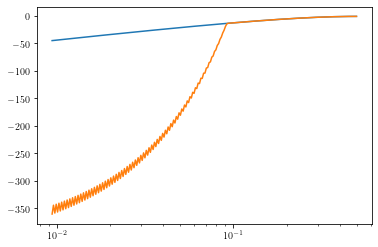

In [76]:
psi_step_test2 = utilities.Psi_Delta_exact(farr[mask_lisa], fstar_test2, c0_test2, Ms, eta, zem, tc, psic, cT_type='step', width=0)

plt.semilogx(farr[mask_lisa], psi_step_GR)
plt.semilogx(farr[mask_lisa], psi_step_test2)

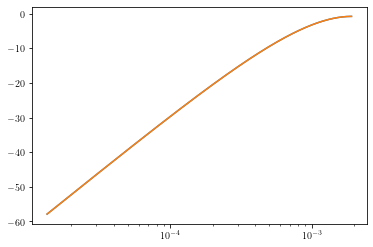

In [63]:
Mtest = 1.e6
Mtest_s = Mtest * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
eta_t = 0.25

Mtot_s = eta_t**(-3./5)*Mtest_s

f_start = (5*Mtest_s/256/time)**(3./8) / np.pi/Mtest_s      # starting frequency at the time before merger

fc = utilities.inspiral_fc(Mtot_s)

ftest = np.logspace(np.log10(f_start),np.log10(fc),num=500)

psi_step_GR2 = Psi_Delta_exact(ftest, 1e-4, 1, Mtest, eta_t, zem, tc, psic, cT_type='step', width=0)
psi_step_test2 = Psi_Delta_exact(ftest, 1e-4, c0_test2, Mtest, eta_t, zem, tc, psic, cT_type='step', width=0)

plt.semilogx(ftest, psi_step_GR2)
plt.semilogx(ftest, psi_step_test2)

In [64]:
pars_step_test3 = [np.log(Mtest), np.log(eta_t), np.log(zem), tc, psic, c0_test2, 1.e-4]

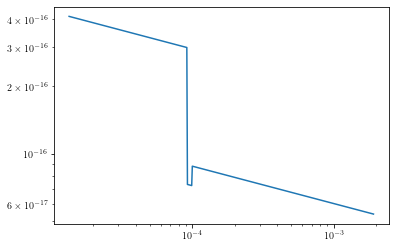

In [69]:
h_Delta_step_test3 = waveform_delta(cT_type='step', width=w).h_Delta_exact(ftest, pars_step_test3, cosmo_params)

plt.loglog(ftest, np.abs(ftest*h_Delta_step_test3), label='GW150914 step')


In [74]:
Delta = Delta_step(ftest,c0_test2,zem,1.e-4,w)

d_Delta_dfo_func = lambda fo_func: Delta_step(fo_func, c0_test2, zem, 1.e-4, w)

d_Delta_dfo = derivative(d_Delta_dfo_func, ftest, ftest*1e-3)

d_Delta_dfo_func = lambda fo_func: Delta_step(fo_func, 1, zem, 1.e-4, w)

d_Delta_dfo_GR = derivative(d_Delta_dfo_func, ftest, ftest*1e-3)

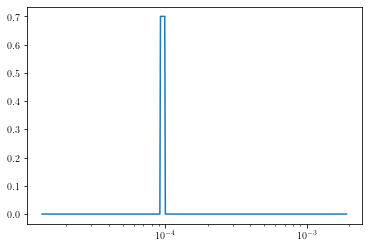

In [75]:
plt.semilogx(ftest, Delta)

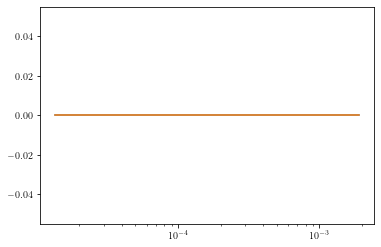

In [73]:
plt.semilogx(ftest, d_Delta_dfo_GR)
plt.semilogx(ftest, d_Delta_dfo)

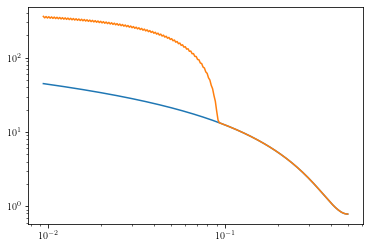

In [54]:
psi_step_test2 = Psi_Delta_exact(farr[mask_lisa], fstar_test2, c0_test2, Ms, eta, zem, tc, psic, cT_type='step', width=0)

plt.loglog(farr[mask_lisa], np.abs(psi_step_GR))
plt.loglog(farr[mask_lisa], np.abs(psi_step_test2))